**Примечание**: Тетрадка переписывалась и перезапускалась мильен раз, потому что первоначально тут был взрыв на макаронной фабрике, поэтому итоговые результаты прогона моделек могут быть не лучшими (лучшие мы заботливо загрузили на каггл)

In [34]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
import xgboost as xgb
import catboost as cat

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

In [26]:
# Загрузка и анализ датасета
trainfull = pd.read_csv('train.csv')
trainfull.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,1.134505e+01,-7.250968e+01,3.991979e+01,-7.251121e+01,3.992068e+01,1.685380e+00
std,2.071083e+01,1.284888e+01,9.642353e+00,1.278220e+01,9.633346e+00,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


Видим, что 1) есть отрицательные цены за поездку: это не похоже на правду 2) количество пассажиров отрицательным, к счастью, не может быть, а вот 200 пассажиров в максимуме - подозрительно

In [27]:
# Полный датасет мы не потянем (даже на 32 гб), поэтому оставим для шустрых моделек 6 млн строк - из которых часть выкинется при обработке, а для медленных - 1 млн
train = trainfull.sample(1000000)
del trainfull
datasample = train.sample(20000)
test = pd.read_csv('test.csv')

Дефайним функции для обработки датасета

In [4]:
def add_new_features(df):
    '''Функция создания новых признаков'''
    
    # 1. Разница по модулю широты и долготы
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

    # 2. Признаки даты и вермени: год, месяц, день, день недели. Данные берём из столбца key.
    df['key_added'] = pd.to_datetime(df.key, format="%Y-%m-%d %H:%M:%S")
    df.key.value_counts()
    df['year'] = df.key_added.dt.year
    df['month'] = df.key_added.dt.month
    df['day'] = df.key_added.dt.day
    df['day_of_the_week'] = df.key_added.dt.dayofweek
    df["hour"] = df.key_added.dt.hour
    
    
    # 3. Начало/завершение поездки в одном из аэропортов NYC

    # 3.1 Координаты аэропортов NYC
    nyc_airports = {'JFK': {'min_lng': -73.835,
                            'min_lat': 40.619,
                            'max_lng': -73.740,
                            'max_lat': 40.665},

                    'EWR': {'min_lng': -74.192,
                            'min_lat': 40.670,
                            'max_lng': -74.153,
                            'max_lat': 40.708},

                    'LaGuardia': {'min_lng': -73.889,
                                  'min_lat': 40.766,
                                  'max_lng': -73.855,
                                  'max_lat': 40.793}
                    }

    # 3.2 Функция, возвращающая 1, если начал/завершил поездку в аэропорту и 0 иначе
    def airport(latitude, longitude, airport_name):
        if (latitude >= nyc_airports[airport_name]['min_lat'] and
            latitude <= nyc_airports[airport_name]['max_lat'] and
            longitude >= nyc_airports[airport_name]['min_lng'] and
            longitude <= nyc_airports[airport_name]['max_lng']):
            return 1
        return 0
        
    # 3.3 Непосредственное добавление признаков в датасет
    df['pick_up_JFK'] = df.apply(lambda row: airport(
        row['pickup_latitude'], row['pickup_longitude'], 'JFK'), axis=1)
    df['dropoff_JFK'] = df.apply(lambda row: airport(
        row['dropoff_latitude'], row['dropoff_longitude'], 'JFK'), axis=1)
    df['pickup_EWR'] = df.apply(lambda row: airport(
        row['pickup_latitude'], row['pickup_longitude'], 'EWR'), axis=1)
    df['dropoff_EWR'] = df.apply(lambda row: airport(
        row['dropoff_latitude'], row['dropoff_longitude'], 'EWR'), axis=1)
    df['pickup_la_guardia'] = df.apply(lambda row: airport(
        row['pickup_latitude'], row['pickup_longitude'], 'LaGuardia'), axis=1)
    df['dropoff_la_guardia'] = df.apply(lambda row: airport(
        row['dropoff_latitude'], row['dropoff_longitude'], 'LaGuardia'), axis=1)

  
  

    # 4. Дистанция поездки
    def trip_distance(lat1, lat2, lon1, lon2):
        p = 0.017453292519943295  # Pi/180
        a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * \
            np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
        return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

    df['trip_distance'] = df.apply(lambda row: trip_distance(
            row['pickup_latitude'], row['dropoff_latitude'], row['pickup_longitude'], row['dropoff_longitude']), axis=1)
    return df

# source: "https://www.kaggle.com/dster/nyc-taxi-fare-starter-kernel-simple-linear-model"
# source: "https://www.kaggle.com/hamzaabdelhedi/quick-look-into-nyc-starter-kernel"

In [5]:
def data_cleaning(df):
    '''Функция очистки данных'''

    # Удаляем избыточный столбец pickup_datetime, поскольку добавили признаки в функции add_new_features
    if 'pickup_datetime' in df:
        df.drop("pickup_datetime", axis = 1, inplace=True)
    
    # удаляем строки с нулевыми значениями
    df = df.dropna(how = 'any', axis = 'rows') 
    
    # удаляем строки со стоимостью поездки меньше 0
    if 'fare_amount' in df: 
        df = df[df['fare_amount'] > 0]

    # удаляем строки, где кол-во пассажиров меньше 1 или больше 9
    df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 9)]
    
    # Учитывая, что поездки совершаются в рамках одного города, разница широты и долготы не должна превышать 1
    # (1 градус долготы это приблизительно 69 миль). Следовательно, стоит исключить из датасета строки с слишком
    # большим показателем разницы широты или долготы.
    df = df[(df.abs_diff_longitude < 5.0) & (df.abs_diff_latitude < 5.0)]
    
    return df

In [6]:
def normalization(df):
    '''Функция нормализации признаков'''

    # a dictionary with NYC coordinates from test data that will be used in deleting outliers
    coordinates = {'min_long': min(test.pickup_longitude.min(), test.dropoff_longitude.min()),
                   'max_long': max(test.pickup_longitude.max(), test.dropoff_longitude.max()),
                   'min_lat': min(test.pickup_latitude.min(), test.dropoff_latitude.min()),
                   'max_lat': min(test.pickup_latitude.max(), test.dropoff_latitude.max()), }

    df.year = (df.year - 2009)
    max_year = df.year.max()
    df.month = df.month + df.year * 12
    df.year = df.year / max_year
    max_month = df.month.max()
    df.month = df.month / max_month
    max_day = df.day.max()
    df.day = df.day / max_day
    max_hour = df.hour.max()
    df.hour = df.hour / max_hour
    df.pickup_latitude = coordinates['max_lat'] - df.pickup_latitude
    df.dropoff_latitude = coordinates['max_lat'] - df.dropoff_latitude
    df.pickup_longitude = coordinates['max_long'] - df.pickup_longitude
    df.dropoff_longitude = coordinates['max_long'] - df.dropoff_longitude
    
    return df
    
    # source: "https://www.kaggle.com/hamzaabdelhedi/quick-look-into-nyc-starter-kernel"

In [28]:
# обрабатываем обучающие данные и передаём их в переменные X_test и y_test
train = add_new_features(train)
train = data_cleaning(train)
train = normalization(train)

y_train = train.fare_amount.copy()

X_train = train.drop("fare_amount", axis=1)
X_train = X_train.drop(["key", "key_added"], axis=1)

# обрабатываем тестовые данные и передаём их в переменную X_test

test = add_new_features(test)
test = data_cleaning(test)
test = normalization(test)

y_test = test["key"]
X_test = test.drop(["key", "key_added"], axis=1)

# обрабатываем 10к строк для гридсерча

datasample = add_new_features(datasample)
datasample = data_cleaning(datasample)
datasample = normalization(datasample)
datasample.drop(['key', 'key_added'], axis=1, inplace=True)


del train, test  # экономим оперативу

Посмотрим, что получилось...

<AxesSubplot:>

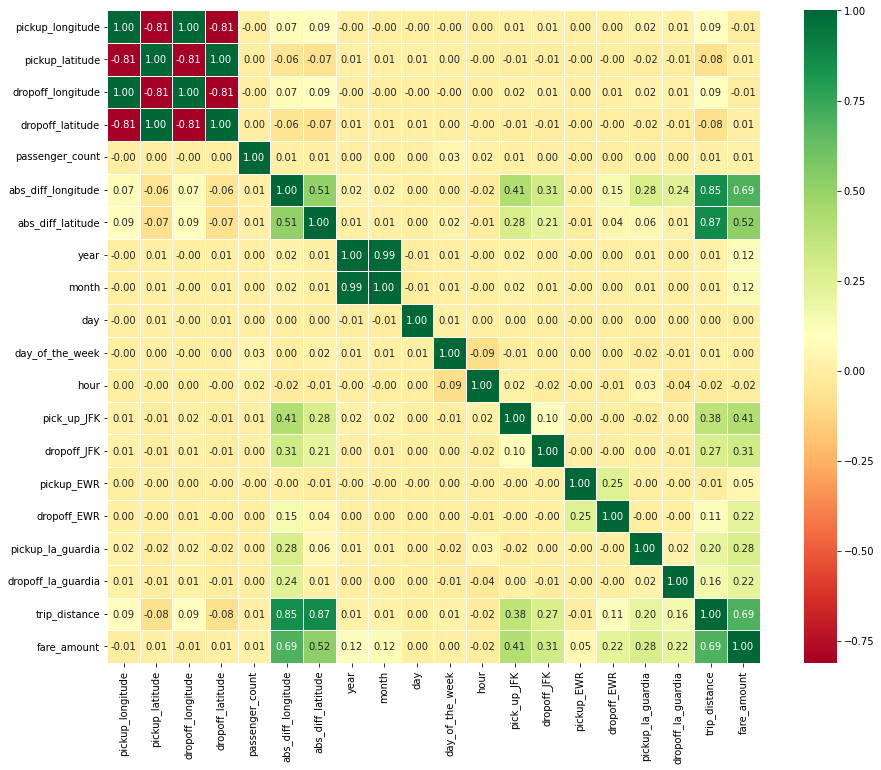

In [8]:
plt.figure(figsize=(16, 12))

corr = pd.concat([X_train, y_train], axis=1).corr()

sns.heatmap(corr,annot=True,linewidths=.5, fmt= '.2f', 
            mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.color_palette('RdYlGn', as_cmap=True), square=True)

Гридсерчить на таком огромном материале тяжело, поэтому сделаем небольшой сэмпл чисто под гридсерч (но гридсерчили мы не все)

In [19]:
def tuning(model, params):
    """Функция подбора параметров"""
    grid = GridSearchCV(model, param_grid=params, scoring='neg_root_mean_squared_error', cv=5)
    grid.fit(datasample.drop('fare_amount', axis=1), datasample['fare_amount'])
    print(grid.best_params_)
    return grid.best_estimator_

In [8]:
def fitting(model, name):
    """Функция обучения модельки"""
    print(f'Started training {name}')
    model.fit(X_train, y_train)
    print(f'Predicting...')
    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)
    print(f'{name} RMSE train:', mean_squared_error(y_train, pred_train, squared = False))
    return pred_test, pred_train, name

In [9]:
def writeres(pred_test, pred_train, name):
    """Функция для записи результата"""
    pred_csv = pd.concat([y_test, pd.Series(pred_test)], axis=1)
    pred_csv.rename(columns={0: "fare_amount"}, inplace=True)
    pred_csv.to_csv(f'{name}.csv', index=False)

Тренировка моделек

In [13]:
# Линейная модель - бейзлайн
writeres(*fitting(LinearRegression(), 'Linear Regression'))

Started training Linear Regression
Predicting...
Linear Regression RMSE train: 6.055849977690197


Линейная модель отработала на 6М строк; Standard Baggging, Random Forest & Gradient Boosting - на 1М, три последние тоже на 6М. Мы пробовали также 3 и 5 млн, но больше 2-х эти три слишком долго обучаются, да и качество не то чтобы улучшалось

In [30]:
# Standard Bagging
best = tuning(BaggingRegressor(), {'n_estimators': range(10, 51, 10)})
writeres(*fitting(best, 'Bagging'))

{'n_estimators': 40}
Started training Bagging
Predicting...
Bagging RMSE train: 2.242034744650082


Была еще идея у леса тьюнить max_depth, потому что он переобучается, но гридсерч - это слишком мучительно, а рандомные ограничения длины дали ухудшение качества

In [32]:
# Random Forest
best = tuning(RandomForestRegressor(), {'n_estimators': [80, 90, 100, 110, 120]})
writeres(*fitting(best, 'Random Forest'))

{'n_estimators': 120}
Started training Random Forest
Predicting...
Random Forest RMSE train: 2.0520888478457273


In [36]:
# Gradient Boosting
writeres(*fitting(GradientBoostingRegressor(criterion='squared_error'), 'SkLearn Gradient Boosting'))

Started training SkLearn Gradient Boosting
Predicting...
SkLearn Gradient Boosting RMSE train: 5.395754088264874


In [10]:
# XGBoost
writeres(*fitting(xgb.XGBRegressor(objective="reg:squarederror", n_estimators=120, max_depth=7, random_state=42), 'XGBoost, params'))

Started training XGBoost, params
Predicting...
XGBoost, params RMSE train: 3.967862583262601


In [11]:
# CatBoost
writeres(*fitting(cat.CatBoostRegressor(n_estimators=120), 'Cat Boost, estimators=120'))

Started training Cat Boost, estimators=120
Learning rate set to 0.5
0:	learn: 6.6446787	total: 461ms	remaining: 54.9s
1:	learn: 5.3991135	total: 649ms	remaining: 38.3s
2:	learn: 4.9284488	total: 823ms	remaining: 32.1s
3:	learn: 4.7722431	total: 978ms	remaining: 28.4s
4:	learn: 4.6910260	total: 1.13s	remaining: 26s
5:	learn: 4.6278080	total: 1.29s	remaining: 24.4s
6:	learn: 4.5949607	total: 1.45s	remaining: 23.4s
7:	learn: 4.5459407	total: 1.6s	remaining: 22.4s
8:	learn: 4.5148551	total: 1.74s	remaining: 21.5s
9:	learn: 4.4879391	total: 1.91s	remaining: 21.1s
10:	learn: 4.4583752	total: 2.08s	remaining: 20.6s
11:	learn: 4.4413004	total: 2.25s	remaining: 20.2s
12:	learn: 4.4296783	total: 2.41s	remaining: 19.9s
13:	learn: 4.4225426	total: 2.57s	remaining: 19.5s
14:	learn: 4.4067268	total: 2.74s	remaining: 19.2s
15:	learn: 4.3966261	total: 2.91s	remaining: 18.9s
16:	learn: 4.3858275	total: 3.06s	remaining: 18.5s
17:	learn: 4.3772676	total: 3.23s	remaining: 18.3s
18:	learn: 4.3714200	total:

Гридсерч LGBM не сохранен, лучшие параметры применили здесь

In [12]:
# LGBM

hyper_params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_iterations': 50000
    }

writeres(*fitting(lgb.LGBMRegressor(**hyper_params), 'LGBM, params'))

Started training LGBM, params


f:\code\python\python38\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
Predicting...
LGBM, params RMSE train: 2.974393631296377
